In [84]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F 
from pyspark.sql.types import *
from pyspark.sql.window import Window

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
spark = SparkSession.builder.appName("DesafioNestle").getOrCreate()

## Read data

In [3]:
# Definindo o esquema da base de dados
schema = StructType([
    StructField("Cargo", StringType(), True),
    StructField("Nível", StringType(), True),
    StructField("Área", StringType(), True),
    StructField("COD Área", StringType(), True),
    StructField("COD Nível", StringType(), True),
    StructField("Quadro", StringType(), True),
    StructField("Bonus", StringType(), True),
    StructField("Contratacao", StringType(), True),
    StructField("Contratacao extra", StringType(), True),
])
df_cargos = spark.read.csv("C:/Users/sara.tavares/OneDrive - Anheuser-Busch InBev/Desktop/desafio/venv/source/BaseCargos.csv", schema=schema, sep=";", header=True)

In [7]:
schema = StructType([
    StructField("CEP", StringType(), True),
    StructField("Estado", StringType(), True),
    StructField("Região", StringType(), True),
    StructField("Região_extra", StringType(), True)
])
# Adaptação para CSV com separador "|"
df_cep = spark.read.csv("C:/Users/sara.tavares/OneDrive - Anheuser-Busch InBev/Desktop/desafio/venv/source/BaseCEP.csv", schema=schema, sep="|", header=True)

In [5]:
schema = StructType([
    StructField("Cliente", StringType(), True),
    StructField("Valor Contrato Anual", StringType(), True),
    StructField("Quantidade de Serviços", StringType(), True),
    StructField("Cargo Responsável", StringType(), True),
    StructField("CEP", StringType(), True),
    StructField("Data Início Contrato", StringType(), True),
    StructField("Nivel de Importancia", StringType(), True),
    StructField("Nivel de Importancia extra", StringType(), True),
])
# Adaptação para CSV que tinha gaps de lihas em branco
df_clientes = spark.read.option("multiline", "true").csv("C:/Users/sara.tavares/OneDrive - Anheuser-Busch InBev/Desktop/desafio/venv/source/BaseClientes.csv", schema=schema, sep=";", header=True)

In [6]:
schema = StructType([
    StructField("ID RH", StringType(), True),
    StructField("RG", StringType(), True), # sensivel 
    StructField("CPF", StringType(), True), # sensivel 
    StructField("Ramal", StringType(), True),
    StructField("Estado Civil", StringType(), True),  # sensivel 
    StructField("Nome Completo", StringType(), True),
    StructField("Login", StringType(), True), # sensivel 
    StructField("Data de Nascimento", StringType(), True),   
    StructField("CEP", StringType(), True),   
    StructField("Data de Contratacao", StringType(), True),   
    StructField("Data de Demissao", StringType(), True),   
    StructField("Dias Uteis Trabalhados Ano Orcamentario", StringType(), True),   
    StructField("Salario Base", StringType(), True),   
    StructField("Impostos", StringType(), True),   
    StructField("Beneficios", StringType(), True),   
    StructField("VT", StringType(), True),   
    StructField("VR", StringType(), True),   
    StructField("Cargo", StringType(), True),   
    StructField("Bandeira", StringType(), True),   
    StructField("Codigos", StringType(), True),   
    StructField("Quantidade de Acessos", StringType(), True),   
    StructField("Ferias Acumuladas", StringType(), True),   
    StructField("Ferias Remuneradas", StringType(), True),   
    StructField("Horas Extras", StringType(), True),   
    StructField("Valores Adicionais", StringType(), True),   
    StructField("ID de Pessoal", StringType(), True),   
    StructField("ID da area", StringType(), True),   
])
# Adaptação para CSV que tinha formatação com "||"
df_funcionarios = spark.read.csv("C:/Users/sara.tavares/OneDrive - Anheuser-Busch InBev/Desktop/desafio/venv/source/BaseFuncionarios.csv", schema=schema, sep="||", header=True)

In [8]:
schema = StructType([
    StructField("Nível", StringType(), True),
    StructField("Descrição Nível", StringType(), True),
    StructField("Tempo no Nível", StringType(), True), 
    StructField("Plano de Saúde", StringType(), True),
    StructField("Plano Odontológico", StringType(), True),   
    StructField("Setor Responsável", StringType(), True),
    StructField("Plano de Carreira", StringType(), True),  
])
# Adaptação para CSV que tinha formatação com "%"
df_nivel = spark.read.csv("C:/Users/sara.tavares/OneDrive - Anheuser-Busch InBev/Desktop/desafio/venv/source/BaseNível.csv", schema=schema, sep="%", header=True)

In [9]:
# Insight 1 -> A base PQ, sem informações adicionais, não traz nada além do que as outras bases fornecem, porém traz uma versão de cada base tratada. Dá a entender que seria um DexPara de como
# as traativas feitas nas outras bases deveriam ficar.

df_pq = spark.read.csv("C:/Users/sara.tavares/OneDrive - Anheuser-Busch InBev/Desktop/desafio/venv/source/BasePQ.csv", sep=";", header=True)

## Transform data

In [10]:
class TransformData():
    """
    Classe TransformData para organizar funções de transformação comunmente usadas entre as bases, evitando repetição de código.
    """
    def __init__(self):
        ...


    def remove_blank_spaces(self, dataframe):
        """
        dataframe -> Obrigatório
            caso os dados de uma determinada coluna de uma dada tabela tiver espaços a mais que não deveria haver na célula, a função usará
            o método ltrim do spark.functions para remover esses espaços.
        """

        dataframe = dataframe.select(*[F.ltrim(F.col(col_name)).alias(col_name) for col_name in dataframe.columns])
        
        return dataframe
    
    
    def remove_specials_caracter(self, dataframe):
        """
        dataframe -> Obrigatório
            caso os dados de uma determinada coluna de uma dada tabela tiver caracteres especiais que não sejam letras do alfabeto brasileiro, tais como: @, %, $, & e etc., 
            estes são removidos, a função não elimina acentuações e cedilha.
        """
        
        for column in dataframe.columns:            
            dataframe = dataframe.withColumn(column, F.regexp_replace(F.col(column), "[^a-zA-Z0-9çÇáéíóúãõâêîôûÀÉÍÓÚÁÉÍÓÚãõÃÕâêîôûüÜ]", ""))
        
        return dataframe
    
    
    def column_name_pattern(self, dataframe):
        """
        dataframe -> Obrigatório
            Padroniza os nomes das colunas do dataframe, trocando acentuações, cedilha e espaços por letras correspondentes não acentuadas, letra c comum e underline, repectivamente.
        """

        for old_col_name in dataframe.columns:
            new_col_name = (old_col_name
                            .lower()  
                            .replace(" ", "_")  
                            .replace("á", "a")
                            .replace("é", "e")
                            .replace("í", "i")
                            .replace("ó", "o")
                            .replace("ú", "u")
                            .replace("ã", "a")
                            .replace("õ", "o")
                            .replace("â", "a")
                            .replace("ê", "e")
                            .replace("î", "i")
                            .replace("ô", "o")
                            .replace("û", "u")
                            .replace("ç", "c")
                        )
            dataframe = dataframe.withColumnRenamed(old_col_name, new_col_name)
            
        return dataframe



In [11]:
obj = TransformData()

df_cargos_temp = obj.remove_blank_spaces(df_cargos)
df_cargos_temp = obj.remove_specials_caracter(df_cargos_temp)
df_cargos_temp = obj.column_name_pattern(df_cargos_temp)

df_cep_temp = obj.column_name_pattern(df_cep)

df_clientes_temp = obj.column_name_pattern(df_clientes)

df_funcionarios_temp = obj.column_name_pattern(df_funcionarios)

df_nivel_temp = obj.column_name_pattern(df_nivel)

In [12]:
#============= CARGOS
"""
A base de Cargos tinha vários problemas de formatação:
- caracteres especiais, removidos com a função remove_specials_caracter
- espaços em branco nas células, removidos com remove_blank_spaces
- problema comum entre todas as bases: colunas com nomes 'sujos' com acentuações, cedilha e espaços, reformatados com a função column_name_pattern
- algumas linhas foram formatadas com TAB, o que ocasionou a quebra da informação, criando novas linhas sem informações em outras colunas, foi tratado da forma àbaixo:
"""
# Filtrando linhas que quebraram e ficaram sem informação na coluna Nível
df = (df_cargos_temp.filter(F.col("nivel").isNull())).drop("nivel")

# Reorganizando posição das informações do dataframe filtrado
df = df.withColumnRenamed("area","nivel").withColumnRenamed("cod_area","area").withColumnRenamed("cod_nivel","cod_area").withColumnRenamed("quadro","cod_nivel").withColumnRenamed("bonus","quadro").withColumnRenamed("contratacao","bonus").withColumnRenamed("contratacao_extra","contratacao")

# Filtrando as linhas não corrompidas do dataframe para agregar com o dataframe filtrado e tratado
df_cargos_temp = df_cargos_temp.filter(F.col("nivel").isNotNull()).drop("contratacao_extra")

df_join_cargos = df_cargos_temp.unionByName(df)

#============= CEP
""" 
Além dos mesmos problemas de padrões dos nomes das colunas, a base de Cep tinha o seguinte problema:
- colunas vazias, ocasionando na criação de uma coluna extra à direita para receber as informações que deveriam estar à esquerda, se não fosse pela má formatação com dois pipes, em vez de um
como é o padrão da base. Foi necessário filtrar as linhas que tinham a coluna à esquerda sem o dado que deveria, tratar a posição das colunas e reagregar à base original tratada Sem as linhas
corrompidas.
"""
# Filtragem das linhas corrompidas e reorganização das colunas
df = (df_cep_temp.filter(F.col("estado").isNull()))
df = df.withColumnRenamed("regiao","estado2")
df = df.withColumnRenamed("regiao_extra","regiao").drop("estado")
df = df.withColumnRenamed("estado2","estado")

# Filtragem do df original sem as linhas corrompidas para a reagregação das informações
df_cep_temp = (df_cep_temp.filter(F.col("Estado").isNotNull())).drop("regiao_extra")

df_join_cep = df_cep_temp.unionByName(df)

# ============= CLIENTES
""" 
A base clientes era a mais despadronizadas, com vários problemas, além dos comuns entre as bases nos nomes das colunas:
- Várias colunas tinham suas informações trocadas 
- A posição das informações trocadas não era a mesma em todos os casos
- As colunas que faltavam informações não eram as mesmas em todos os casos
"""

# Filtragem de cada caso de desformatação encontrado e filtragem da base original sem nenhum caso corrompido 
df = df_clientes_temp.filter((F.col("cep").isNull()) & (F.col("data_inicio_contrato").isNull()) & (F.col("nivel_de_importancia").isNull()) & (F.col("cargo_responsavel").isNotNull()))
df_aux = df_clientes_temp.filter((F.col("cep").isNull()) & (F.col("data_inicio_contrato").isNull()) & (F.col("nivel_de_importancia").isNull()) & (F.col("cargo_responsavel").isNull()))
df_qntd_serv_null = df_clientes_temp.filter((F.col("quantidade_de_servicos").isNull()))
df_valor_contrato_anual_null = df_clientes_temp.filter((F.col("valor_contrato_anual").isNull()))

df_limpa = df_clientes_temp.filter((F.col("cep").isNotNull()) & (F.col("data_inicio_contrato").isNotNull()) & (F.col("nivel_de_importancia").isNotNull()) & (F.col("cargo_responsavel").isNotNull()) & (F.col("quantidade_de_servicos").isNotNull()) & (F.col("valor_contrato_anual").isNotNull()))

# Reorganização das informaçoes e select para reagregar às outras bases corrompidas após tratamento 
df = df.withColumnRenamed("cargo_responsavel","cargo_responsavel2").drop('cep','data_inicio_contrato')
df = df.withColumn("cargo_responsavel", F.col('cliente')).withColumn("cep", F.col('valor_contrato_anual')).withColumn("data_inicio_contrato", F.col('quantidade_de_servicos')).withColumn("nivel_de_importancia", F.col('cargo_responsavel2'))

df = df.select(
    "cargo_responsavel",
    "cep",
    "data_inicio_contrato",
    "nivel_de_importancia",
)

df_aux = df_aux.select(
     'cliente','valor_contrato_anual','quantidade_de_servicos', 'nivel_de_importancia_extra'
)

df_qntd_serv_null = df_qntd_serv_null.drop("quantidade_de_servicos")
df_qntd_serv_null = df_qntd_serv_null.withColumn("quantidade_de_servicos", F.col('cargo_responsavel')).withColumn("cargo_responsavel", F.col('cep')).withColumn("cep", F.col('data_inicio_contrato')).withColumn("data_inicio_contrato", F.col('nivel_de_importancia')).withColumn("nivel_de_importancia", F.col('nivel_de_importancia_extra')).withColumn("nivel_de_importancia_extra", F.lit(''))

df_valor_contrato_anual_null = df_valor_contrato_anual_null.withColumn('valor_contrato_anual', F.col("quantidade_de_servicos")).withColumn('quantidade_de_servicos', F.col("cargo_responsavel")).withColumn('cargo_responsavel', F.col("cep")).withColumn('cep', F.col("data_inicio_contrato")).withColumn('data_inicio_contrato', F.col("nivel_de_importancia")).withColumn('nivel_de_importancia', F.col("nivel_de_importancia_extra")).withColumn('nivel_de_importancia_extra', F.lit(""))

# Adicionando uma coluna sequencial numérica como chave primária para reagregar as informações à linha correta dos dataframes tratados e por fim agregação ao dataframe original sem informações corrompidas
df = df.withColumn("id", F.monotonically_increasing_id())
df_aux = df_aux.withColumn("id", F.monotonically_increasing_id())

df_join_clientes_aux = df_aux.join(df, ['id'], 'left').dropDuplicates().drop('id')

df_join_clientes = df_qntd_serv_null.unionByName(df_join_clientes_aux)
df_join_clientes = df_join_clientes.unionByName(df_limpa)
df_join_clientes = df_join_clientes.unionByName(df_valor_contrato_anual_null)

# ============= Funcionários
""" 
Na base Funcionarios o problema latente encontrado foi a formatação das colunas de datas, que veio da origem formatadas como data serial e foi necessários vários testes até encontrar a 
data de referência do banco e poder transformar para unix timestamp, trazendo de volta a formatação yyyy-MM-dd
Além disso a base possuia informações pessoais segundo a LGPD, para tratá-las removi do dataframe tratado essas informações, mas criei uma chave comum entre as bases 
para, caso algum time de comliance ou similar precise, dentro dos limites da lei, possamos reagregar as informações para um fim legítimo.
"""
# Tratamento das colunas com datas seriais
df_funcionarios_temp = df_funcionarios_temp.withColumn("data_de_nascimento", F.from_unixtime(F.col("data_de_nascimento")*86400 + F.unix_timestamp(F.lit("1899-12-30"), "yyyy-MM-dd"), "yyyy-MM-dd"))\
    .withColumn("data_de_contratacao", F.from_unixtime(F.col("data_de_contratacao")*86400 + F.unix_timestamp(F.lit("1899-12-30"), "yyyy-MM-dd"), "yyyy-MM-dd"))\
    .withColumn("data_de_demissao", F.from_unixtime(F.col("data_de_demissao")*86400 + F.unix_timestamp(F.lit("1899-12-30"), "yyyy-MM-dd"), "yyyy-MM-dd"))

# Criação de chave para tratamento dos dados pessoais
df_funcionarios_temp = df_funcionarios_temp.withColumn(
    "sensitive_key",
    F.concat(
        F.substring("rg", 1, 3),  
        F.col("cargo"),            
        F.substring("cpf", -4, 4) 
    )
)

# Criação da base com dados pessoais 
df_sensivel = df_funcionarios_temp.select(
    "rg","cpf",
    "estado_civil",
    "login",
    "cep",
    "salario_base", 
    "sensitive_key"
)

# Remoção das informações pessoais da base original tratada
df_funcionarios_temp = df_funcionarios_temp.drop("rg","cpf","estado_civil","login","cep","salario_base")

######################## Nível
""" 
A base Nível não tinha nenhuma coluna como chave única e estava desformatada com quebra de linha como a base Clientes. Após a filtragem das linhas corrompidas,
foi observado que não haveria uma forma de reagregar sem algum tipo de chave única comum entre a tabela com dados corrompidos tratados e a tabela original sem dados corrompidos.
A base PQ foi de ajuda neste momento, pois tinha as informações necessárias para serem usadas como chave única. 
"""
# Filtragem dos casos corrompidos
df_sem_nivel = df_nivel_temp.filter((F.col("nivel").isNotNull()) & (F.col("plano_de_saude").isNotNull()) & (F.col("plano_odontologico").isNull()))
df_com_nivel = df_nivel_temp.filter((F.col("nivel").isNotNull()) & (F.col("plano_de_saude").isNull()) & (F.col("plano_odontologico").isNull()))
df_nivel_vazio = df_nivel_temp.filter((F.col("nivel").isNull()) & (F.col("plano_de_saude").isNotNull()) & (F.col("plano_odontologico").isNotNull()))

# Reorganização das informações
df_nivel_vazio = df_nivel_vazio.withColumn(
    "plano_de_carreira",F.when(F.col("plano_de_carreira").isNull(), F.col("plano_odontologico")),
)

df_nivel_vazio = df_nivel_vazio.withColumn(
    "setor_responsavel", F.when(F.col("setor_responsavel").isNull(), F.col("plano_de_saude")),
)

df_nivel_vazio = df_nivel_vazio.withColumn(
    "plano_odontologico", F.col("tempo_no_nivel"),
)

df_nivel_vazio = df_nivel_vazio.withColumn(
    "plano_de_saude", F.col("descricao_nivel"),
).drop('nivel','descricao_nivel','tempo_no_nivel')

# Reorganização das informações
df_sem_nivel = df_sem_nivel.withColumn(
    "plano_de_carreira",F.when(F.col("plano_de_carreira").isNull(), F.col("plano_de_saude")),
)

df_sem_nivel = df_sem_nivel.withColumn(
    "plano_de_saude", F.col("nivel"),
)

df_sem_nivel = df_sem_nivel.withColumn(
    "plano_odontologico", F.when(F.col("plano_odontologico").isNull(), F.col("descricao_nivel")),
)

df_sem_nivel = df_sem_nivel.withColumn(
    "setor_responsavel", F.when(F.col("setor_responsavel").isNull(), F.col("tempo_no_nivel")),
).drop('nivel','descricao_nivel','tempo_no_nivel')

dj_join_sem_nivel = df_sem_nivel.unionByName(df_nivel_vazio)

# Join na base PQ apenas com as colunas de chave única
df_join_nivel = df_pq.join(dj_join_sem_nivel, [
    dj_join_sem_nivel.setor_responsavel == df_pq["Setor Responsável"],
    dj_join_sem_nivel.plano_odontologico == df_pq["Plano Odontológico"],
    dj_join_sem_nivel.plano_de_carreira == df_pq["Plano de Carreira"]
    ], 'left').select(
        df_pq["Nível51"].alias("nivel"),
        df_pq["Descrição Nível"],
        df_pq["Tempo no Nível"],
        dj_join_sem_nivel['setor_responsavel'],
        dj_join_sem_nivel['plano_odontologico'],
        dj_join_sem_nivel['plano_de_carreira'],
        dj_join_sem_nivel['plano_de_saude'],
    ).dropDuplicates().na.drop(how = "all")

df_join_nivel = obj.column_name_pattern(df_join_nivel)

In [163]:
"""
Foi optado por não fazer nenhum tratamento para a base PQ, visto que a conclusão da observação desta base concluiu que seria uma base de apoio, já que aparenta ser um join
entre todas as outras bases em suas versões tratadas porém sem nenhum tipo de tratamento no join.
"""

In [14]:
# Salvando as bases tratadas, sem relacionamento entre si 
df = df_join_cargos.toPandas()
df.to_csv("C:/Users/sara.tavares/OneDrive - Anheuser-Busch InBev/Desktop/desafio/venv/transformed/BaseCargosTratato.csv", sep=";", index=False)

df = df_join_cep.toPandas()
df.to_csv("C:/Users/sara.tavares/OneDrive - Anheuser-Busch InBev/Desktop/desafio/venv/transformed/BaseCEPTratato.csv", sep=";", index=False)

df = df_join_clientes.toPandas()
df.to_csv("C:/Users/sara.tavares/OneDrive - Anheuser-Busch InBev/Desktop/desafio/venv/transformed/BaseClientesTratato.csv", sep=";", index=False)

df = df_funcionarios_temp.toPandas()
df.to_csv("C:/Users/sara.tavares/OneDrive - Anheuser-Busch InBev/Desktop/desafio/venv/transformed/BaseFuncionariosTratato.csv", sep=";", index=False)

df = df_sensivel.toPandas()
df.to_csv("C:/Users/sara.tavares/OneDrive - Anheuser-Busch InBev/Desktop/desafio/venv/transformed/BaseSensivelTratato.csv", sep=";", index=False)

df = df_join_nivel.toPandas()
df.to_csv("C:/Users/sara.tavares/OneDrive - Anheuser-Busch InBev/Desktop/desafio/venv/transformed/BaseNivelTratato.csv", sep=";", index=False)

In [15]:
""" 
Com as bases tratadas foi possível então ter insights para a criação de informações relevantes com seus dados:
1º A base funcionários, com dados pessoais tratados, poderia receber mais informações sobre o colaborador e sua posição, consolidando a informação com dados de benefícios fornecidos pela base Cargos
2° A base Clientes também tinha oportunidades de trazer melhores informações, já havia o código do cargo que atende determinado cliente, porém foi trazido também
a área e o nível, visto que pode haver o mesmo cargo em áreas diferentes, e assim com essas informações adicionais, facilitaria para um relacionamento futuro para projetos e KPI's específicos 
para essas informações
3° Ambas bases de funcionários e clientes consolidadas continham informações pessoais dos colaboradores e dos clientes, também resultou em duas novas bases, com chaves unicas, 
removendo das bases originais as informações pessoais.
"""

join_condition_position = [
    (df_join_cargos.cod_nivel == df_join_nivel.nivel)
]
position_consolidated = df_join_cargos.join(df_join_nivel, join_condition_position, 'left').select(
    df_join_cargos['*'],
    df_join_nivel['plano_odontologico'],
    df_join_nivel['plano_de_carreira'],
    df_join_nivel['plano_de_saude'],
).dropDuplicates()

funcionarios_consolidated = df_funcionarios_temp.join(position_consolidated, 'cargo', 'left')

employee_personel_data = df_sensivel.join(df_join_cep, 'cep', 'left')

join_condition_client = [
    df_join_clientes.cargo_responsavel == df_join_cargos.cargo
]
client_consolidated = df_join_clientes.join(df_join_cargos, join_condition_client, 'left').select(
    df_join_clientes['*'],
    df_join_cargos['cod_area'],
    df_join_cargos['cod_nivel'],
)

client_consolidated = client_consolidated.withColumn('personel_key', F.concat(F.regexp_replace(F.col('data_inicio_contrato'), "/", ""), F.col('cargo_responsavel'), F.col('cod_area')))
client_personel_data = client_consolidated.select('valor_contrato_anual','cep','personel_key')

client_consolidated = client_consolidated.drop('valor_contrato_anual','cep')

In [ ]:
df = funcionarios_consolidated.toPandas()
df.to_csv("C:/Users/sara.tavares/OneDrive - Anheuser-Busch InBev/Desktop/desafio/venv/consume/funcionarios_consolidated.csv", sep=";", index=False)

df = employee_personel_data.toPandas()
df.to_csv("C:/Users/sara.tavares/OneDrive - Anheuser-Busch InBev/Desktop/desafio/venv/consume/employee_personel_data.csv", sep=";", index=False)

df = client_personel_data.toPandas()
df.to_csv("C:/Users/sara.tavares/OneDrive - Anheuser-Busch InBev/Desktop/desafio/venv/consume/client_personel_data.csv", sep=";", index=False)

df = client_consolidated.toPandas()
df.to_csv("C:/Users/sara.tavares/OneDrive - Anheuser-Busch InBev/Desktop/desafio/venv/consume/client_consolidated.csv", sep=";", index=False)

### Insights

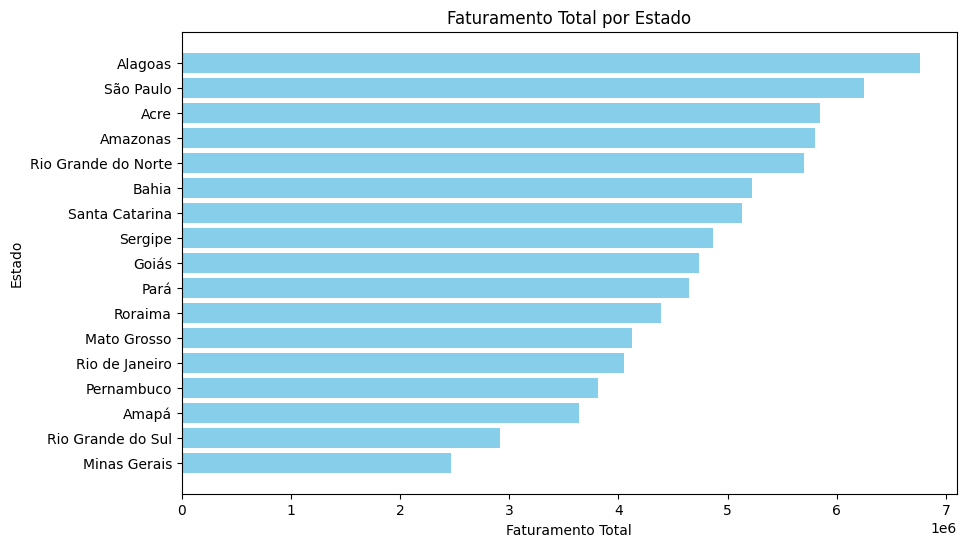

In [68]:
# Geolocalização de clientes com maior faturamento
df_cliente_cep = client_personel_data.join(df_join_cep, 'cep', 'left').select(
    client_personel_data['valor_contrato_anual'].cast('int'),
    df_join_cep['estado']
)
df_grouped = df_cliente_cep.groupBy('estado').agg(F.sum('valor_contrato_anual').alias('soma_faturamento_estado')).orderBy(F.col('soma_faturamento_estado').desc())

# Coletando os dados do DataFrame para visualização
df_grouped = df_grouped.toPandas()

# Criando o gráfico de barras horizontais usando Pandas
plt.figure(figsize=(10, 6))
plt.barh(df_grouped['estado'], df_grouped['soma_faturamento_estado'], color='skyblue')
plt.xlabel('Faturamento Total')
plt.ylabel('Estado')
plt.title('Faturamento Total por Estado')
plt.gca().invert_yaxis()
plt.show()

C:\Users\sara.tavares\AppData\Local\Temp\ipykernel_1724\3546219664.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_pd, x='vantagem', y='estado', palette='deep')


<Axes: xlabel='vantagem', ylabel='estado'>

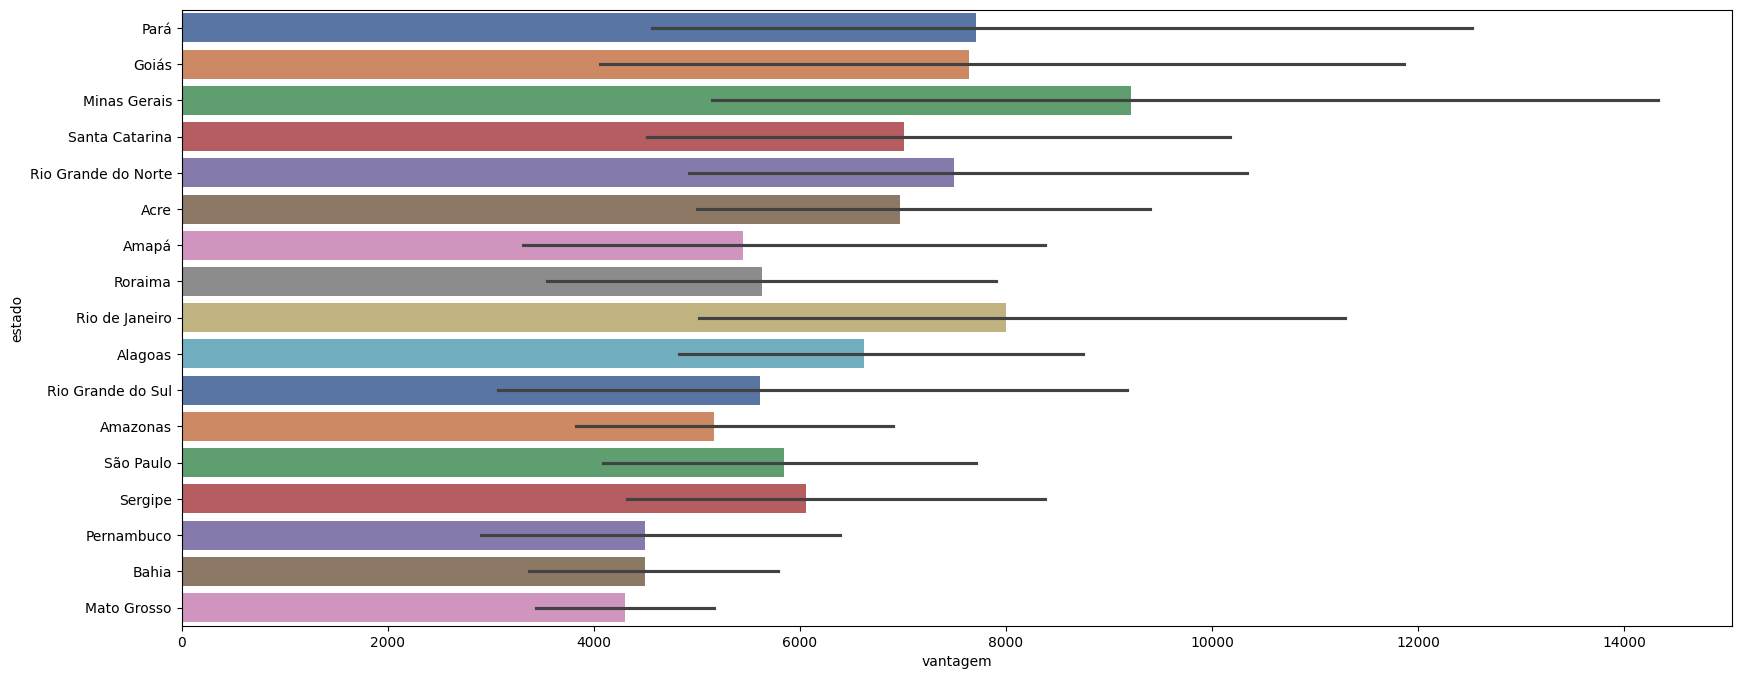

In [105]:
# Geolocalização de clientes mais vantajosos (faturamento x quantidade de serviços contratados). Vantagem = menos serviços x maior faturamento

df_cliente_cep_servicos = client_personel_data.join(client_consolidated, 'personel_key', 'left').select(
    client_personel_data['valor_contrato_anual'].cast('int'),
    client_personel_data['cep'],
    client_consolidated['quantidade_de_servicos']
)
df_cliente_cep_servicos = df_cliente_cep_servicos.join(df_join_cep, 'cep', 'left').select(
    df_cliente_cep_servicos['valor_contrato_anual'].cast('int'),
    df_cliente_cep_servicos['quantidade_de_servicos'],
    df_join_cep['estado'],
    df_join_cep['cep']
)
# Definindo a janela para cálculo da soma dos serviços e do faturamento por cliente
w = Window.partitionBy('cep')

# Calculando a soma do faturamento e da quantidade de serviços contratados por cliente
df_vantagem = df_cliente_cep_servicos.withColumn('faturamento_total', F.sum('valor_contrato_anual').over(w)) \
                                      .withColumn('total_servicos', F.sum('quantidade_de_servicos').over(w))

# Calculando a vantagem para cada cliente
df_vantagem = df_vantagem.withColumn('vantagem', F.col('faturamento_total') / F.col('total_servicos')).dropDuplicates(['cep'])

# Ordenando os clientes com base na vantagem
df_vantagem = df_vantagem.orderBy('vantagem', ascending=False)


# Visualization
df_pd = df_vantagem.toPandas()  

# Criando o gráfico de barras
plt.figure(figsize=(20, 8))
sns.barplot(data=df_pd, x='vantagem', y='estado', palette='deep')

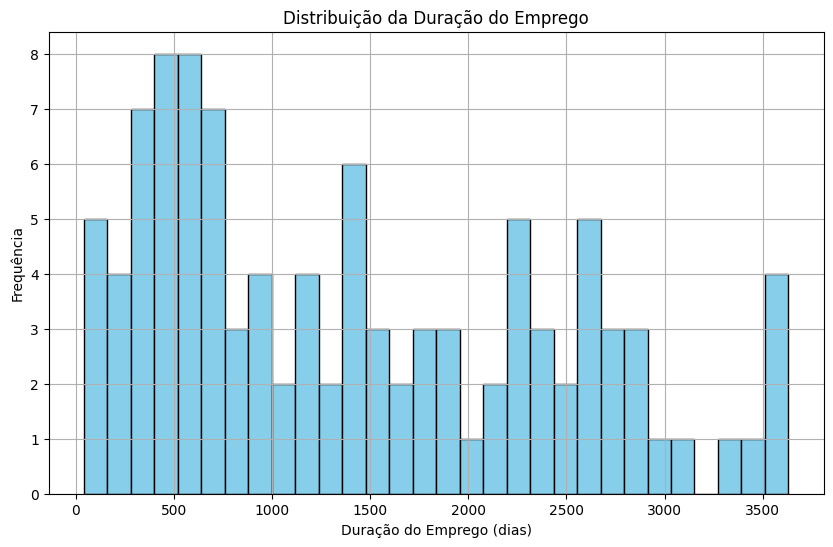

In [128]:
# Relação de tempo de casa x desligamento

# Filtrar os dados para remover registros com valores nulos na coluna 'data_de_demissao'
df_funcionarios_filtrado = funcionarios_consolidated.filter(F.col('data_de_demissao').isNotNull())

# Calcular a duração do emprego (em dias)
df_relacao_tempo_desligamento = df_funcionarios_filtrado.withColumn('dias_de_emprego', F.datediff(F.col('data_de_demissao'), F.col('data_de_contratacao')))

# Criar um histograma para visualizar a distribuição da duração do emprego
dias_emprego = df_relacao_tempo_desligamento.select('dias_de_emprego').toPandas()

plt.figure(figsize=(10, 6))
plt.hist(dias_emprego, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Duração do Emprego (dias)')
plt.ylabel('Frequência')
plt.title('Distribuição da Duração do Emprego')
plt.grid(True)
plt.show()


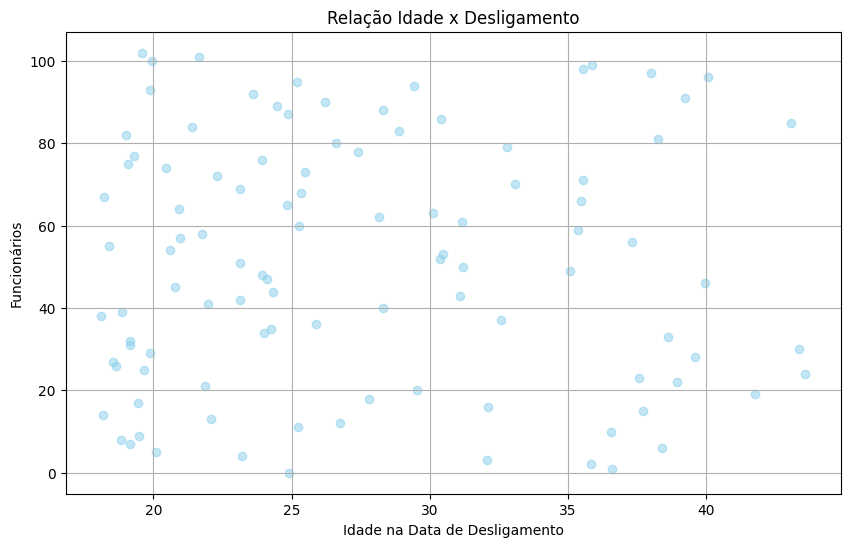

In [139]:
# Relação idade x desligamento

# Calcular a idade na data de desligamento
df_idade_desligamento = funcionarios_consolidated.withColumn('idade_na_demissao', F.expr("datediff(data_de_demissao, data_de_nascimento) / 365.25"))

# Filtrar os dados para remover registros com valores nulos na coluna 'data_de_demissao'
df_idade_desligamento = df_idade_desligamento.filter(F.col('data_de_demissao').isNotNull())

# Coletar os dados para plotagem
df_idade_pd = df_idade_desligamento.select('idade_na_demissao').toPandas()

# Criar o gráfico de dispersão
plt.figure(figsize=(10, 6))
plt.scatter(df_idade_pd['idade_na_demissao'], range(len(df_idade_pd)), color='skyblue', alpha=0.5)
plt.xlabel('Idade na Data de Desligamento')
plt.ylabel('Funcionários')
plt.title('Relação Idade x Desligamento')
plt.grid(True)
plt.show()

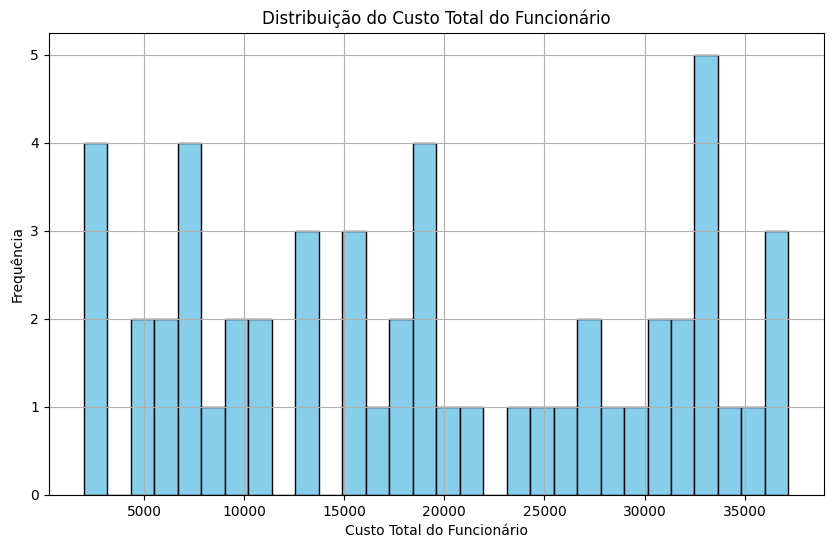

In [145]:
# Relação custo do funcionario (salario + impostos) x desligamento

df_funcionarios_salario = funcionarios_consolidated.join(employee_personel_data, 'sensitive_key', 'left').select(
    employee_personel_data['salario_base'],
    funcionarios_consolidated['*']
)

# Calcular o custo total do funcionário (salário + impostos)
df_custo_funcionario = df_funcionarios_salario.withColumn('custo_total', F.col('salario_base') + F.col('impostos'))

# Filtrar os dados para remover registros com valores nulos na coluna 'data_de_demissao'
df_custo_funcionario = df_custo_funcionario.filter(F.col('data_de_demissao').isNotNull())

# Coletar os dados para plotagem
df_custo_pd = df_custo_funcionario.select('custo_total').toPandas()

# Criar o histograma para visualizar a distribuição do custo total dos funcionários
plt.figure(figsize=(10, 6))
plt.hist(df_custo_pd['custo_total'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Custo Total do Funcionário')
plt.ylabel('Frequência')
plt.title('Distribuição do Custo Total do Funcionário')
plt.grid(True)
plt.show()

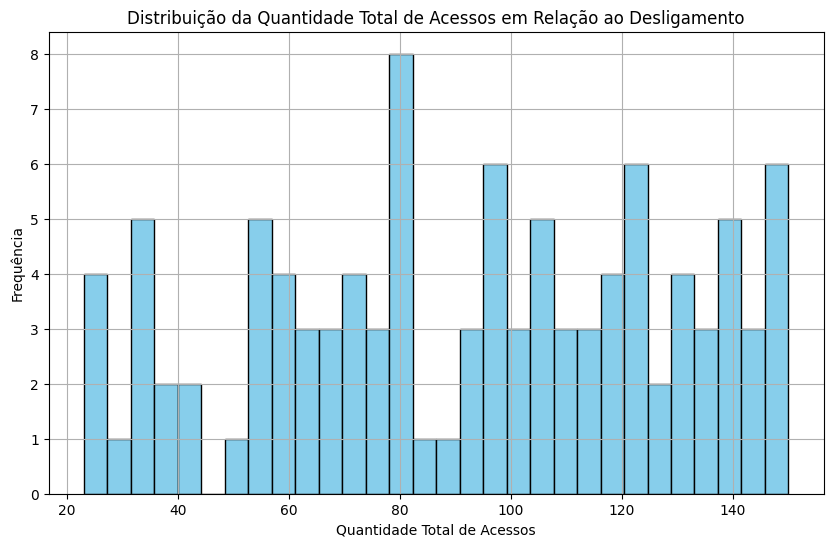

In [150]:
# Relação quantidade de acessos (engajamentos) x desligamento

# Calcular a quantidade total de acessos (engajamentos) por funcionário
df_acessos_total = funcionarios_consolidated.groupBy('sensitive_key').agg(F.sum('quantidade_de_acessos').alias('total_acessos'))

# Filtrar os dados para remover registros com valores nulos na coluna 'data_de_demissao'
df_acessos_total = df_acessos_total.join(funcionarios_consolidated, 'sensitive_key', 'inner').filter(F.col('data_de_demissao').isNotNull())

# Coletar os dados para plotagem
df_acessos_total_pd = df_acessos_total.select('total_acessos').toPandas()

# Criar o histograma para visualizar a distribuição da quantidade total de acessos em relação ao desligamento
plt.figure(figsize=(10, 6))
plt.hist(df_acessos_total_pd['total_acessos'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Quantidade Total de Acessos')
plt.ylabel('Frequência')
plt.title('Distribuição da Quantidade Total de Acessos em Relação ao Desligamento')
plt.grid(True)
plt.show()